# Table of Contents

* [**Preparation**](#Preparation)
* [**Introduction**](#Introduction)
* [**Data Collection**](#Data-Collection)
 * [**Data Preprocessing**](#Data-Preprocessing)
* [**Building and Training the Model**](#Building-and-Training-the-Model)
* [**Qualitative Analysis of Player Vectors**](#Qualitative-Analysis-of-Player-Vectors)
 * [**t-SNE**](#t-SNE)
 * [**PCA**](#PCA)
 * [**ScatterPlot3D**](#ScatterPlot3D)
* [**Player Algebra**](#Player-Algebra)
 * [**Nearest Neighbors**](#Nearest-Neighbors)
 * [**Opposite-handed Doppelgängers**](#Opposite-handed-Doppelgängers)
* [**Modeling Previously Unseen At-Bat Matchups**](#Modeling-Previously-Unseen-At-Bat-Matchups)

# Preparation

I use Python 3, but everything should work with Python 2.

1. Install [HDF5](https://www.hdfgroup.org/HDF5/release/obtain5.html).
2. Install other packages:

<code>pip install h5py keras matplotlib numpy pyyaml scipy scikit-learn seaborn tensorflow theano urllib3</code>

# Introduction

The goal of this project was to learn distributed representations of MLB players. Theoretically, meaningful representations (i.e., representations that capture real baseball qualities of players) could then be used for other types of analyses, such as simulating season outcomes following trades. <code>(batter|pitcher)2vec</code> was inspired by [<code>word2vec</code>](https://en.wikipedia.org/wiki/Word2vec) (hence the name), which is a model that learns distributed representations of words. These learned word vectors often have interesting properties; for example, Paris - France + Italy in the word vector space is very close to the vector for Rome (see [here](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [here](http://arxiv.org/pdf/1301.3781.pdf) for more details). In this notebook, I'll show you how I built a model that simultaneously learns distributed representations of pitchers and batters from at-bat data.

# Data Collection

To start things off, let's download and extract some data from [Retrosheet.org](http://retrosheet.org/). We'll use play-by-play data from the 2013, 2014, 2015, and 2016 seasons.

In [1]:
import urllib.request
import zipfile

from os import makedirs
from os.path import exists

project_directory = "/home/airalcorn2/Projects/batter_pitcher_2vec/batter-pitcher-2vec/" # Change this.
zip_name = "2010seve"
data_directory = project_directory + zip_name

if not exists(data_directory):
    makedirs(project_directory, exist_ok = True)
    zip_f = data_directory + ".zip"
    urllib.request.urlretrieve("http://www.retrosheet.org/events/{0}.zip".format(zip_name), zip_f)
    zip_ref = zipfile.ZipFile(zip_f, "r")
    zip_ref.extractall(project_directory + zip_name)
    zip_ref.close()

And now we'll prepare some variables for organizing the data.

In [2]:
import re

from os import listdir
from os.path import isfile, join

data_files = [f for f in listdir(data_directory) if isfile(join(data_directory, f))]
at_bats = {}
home_runs = {}
singles = {}
doubles = {}
counts = {"batter": {}, "pitcher": {}}

data = {}
train_years = ["2013", "2014", "2015"]
test_year = "2016"
year_match = r"201(3|4|5|6)"
for year in train_years + [test_year]:
    data[year] = []

Next, we'll read in the data. Unfortunately, this is going to be a bunch of spaghetti code. The goal is to collect the batter, pitcher, and outcome (e.g., strike out, home run) for every at-bat. By the end of the following code block, we'll have a Python list of dictionaries where each element has the format <code>{"batter": batter, "pitcher": pitcher, "outcome": outcome}</code>. To best understand what's going on in the code, you'll have to read through Retrosheet's [game file documentation](http://www.retrosheet.org/game.htm).

In [3]:
import string

for data_file in data_files:
    
    year_re = re.search(year_match, data_file)
    if year_re is None:
        continue
    
    year = year_re.group()
    
    # Skip non-event files.
    if not (".EVA" in data_file or ".EVN" in data_file):
        continue
    
    f = open(join(data_directory, data_file))
    home_pitcher = None
    away_pitcher = None
    line = f.readline().strip()
    
    while line != "":
        parts = line.split(",")
        
        # Get starting pitchers.
        if parts[0] == "id":
            while parts[0] != "play":
                line = f.readline().strip()
                parts = line.split(",")
                if parts[0] == "start" and parts[-1] == "1":
                    if parts[3] == "0":
                        away_pitcher = parts[1]
                    else:
                        home_pitcher = parts[1]
        
        # Get at-bat data.
        if parts[0] == "play":
            batter = parts[3]
            pitcher = home_pitcher
            if parts[2] == "1":
                pitcher = away_pitcher
            
            outcome = ""
            
            # Handle balks, intentional, walks, hit by a pitch,
            # strike outs, and walks..
            if parts[-1][:2] in {"BK", "IW", "HP"}:
                outcome = "p_" + parts[-1][:2]
            elif parts[-1][0] in {"K", "I", "W"}:
                outcome = "p_" + parts[-1][0]
            
            # If the last pitch resulted in contact, figure out the pitch outcome.
            # See "Events made by the batter at the plate" here: http://www.retrosheet.org/eventfile.htm#8.
            pitches = parts[5]
            if len(pitches) > 0 and pitches[-1] == "X":
                play_parts = parts[6].split("/")
                main_play = play_parts[0]
                play = main_play.split(".")[0]
                
                if play[0] == "H":
                    play = "HR"
                elif play[0] in string.digits:
                    play = play[0]
                elif play[0] in {"S", "D", "T"}:
                    play = play[:2]
                    # Try to get first ball handler.
                    if len(play) < 2:
                        try:
                            handlers = play_parts[1]
                            if handlers in string.digits:
                                play = play[0] + handlers[0]
                        except IndexError:
                            play = play[0] + "X"
                elif play[:2] == "FC":
                    play = play[2]
                
                outcome = "h_" + play
                
                if play == "HR":
                    home_runs[batter] = home_runs.get(batter, 0) + 1
                elif play[0] == "S":
                    singles[batter] = singles.get(batter, 0) + 1
                elif play[0] == "D":
                    doubles[batter] = doubles.get(batter, 0) + 1
                
            # Ignore catcher interference and ambiguous singles.
            if outcome not in {"h_C", "h_S"} and outcome != "":
                data[year].append({"batter": batter, "pitcher": pitcher, "outcome": outcome})
                at_bats[batter] = at_bats.get(batter, 0) + 1
                counts["batter"][batter] = counts["batter"].get(batter, 0) + 1
                counts["pitcher"][pitcher] = counts["pitcher"].get(pitcher, 0) + 1
        
        # Handle pitcher changes.
        if parts[0] == "sub":
            if parts[-1] == "1":
                if parts[3] == "0":
                    away_pitcher = parts[1]
                else:
                    home_pitcher = parts[1]
        
        line = f.readline().strip()
    
    f.close()

## Data Preprocessing

OK, now that we have our raw data, we're going to establish some cutoffs so that we're only analyzing players with a reasonable number of observations. Let's just focus on the most frequent batters and pitchers who were involved in 90% of the at-bats.

In [4]:
cutoffs = {}
percentile_cutoff = 0.9
for player_type in ["batter", "pitcher"]:

    counts_list = list(counts[player_type].values())
    counts_list.sort(reverse = True)
    total_at_bats = sum(counts_list)

    cumulative_percentage = [sum(counts_list[:i + 1]) / total_at_bats for i in range(len(counts_list))]
    cutoff_index = sum([1 for total in cumulative_percentage if total <= percentile_cutoff])

    cutoff = counts_list[cutoff_index]
    cutoffs[player_type] = cutoff
    print("Original: {0}\tNew: {1}\tProportion: {2:.2f}".format(
            len(counts[player_type]), cutoff_index, cutoff_index / len(counts[player_type])))

Original: 1634	New: 524	Proportion: 0.32
Original: 1226	New: 565	Proportion: 0.46


As you can see, only 32% of batters and 46% of pitchers were involved in 90% of at-bats. Let's use these new cutoff points to build the final data set.

In [5]:
final_data = []
original_data = 0
matchups = set()
for year in train_years:

    original_data += len(data[year])

    for sample in data[year]:

        batter = sample["batter"]
        pitcher = sample["pitcher"]
        matchups.add("{0}_{1}".format(batter, pitcher))

        if counts["batter"][batter] >= cutoffs["batter"] and counts["pitcher"][pitcher] >= cutoffs["pitcher"]:
            final_data.append(sample)

print("Original: {0}\tReduced: {1}".format(original_data, len(final_data)))
print("{0:.2f}% of original data set.".format(len(final_data) / original_data))

Original: 557436	Reduced: 461231
0.83% of original data set.


As you can see, we still retain a large amount of data even after removing infrequent batters and pitchers. Next, we're going to associate an integer index with each of our batters, pitchers, and outcomes, respectively.

In [6]:
import random

FAV_NUM = 2010
random.seed(FAV_NUM)
random.shuffle(final_data)

categories = {"batter": set(), "pitcher": set(), "outcome": set()}
for sample in final_data:
    categories["batter"].add(sample["batter"])
    categories["pitcher"].add(sample["pitcher"])
    categories["outcome"].add(sample["outcome"])

for column in categories:
    categories[column] = list(categories[column])
    categories[column].sort()

NUM_OUTCOMES = len(categories["outcome"])
print("NUM_OUTCOMES: {0}".format(NUM_OUTCOMES))
print(" ".join(categories["outcome"]))

category_to_int = {}
for column in categories:
    category_to_int[column] = {categories[column][i]: i for i in range(len(categories[column]))}

NUM_OUTCOMES: 49
h_1 h_2 h_3 h_4 h_5 h_6 h_7 h_8 h_9 h_D1 h_D3 h_D4 h_D5 h_D6 h_D7 h_D8 h_D9 h_DG h_E1 h_E2 h_E3 h_E4 h_E5 h_E6 h_E7 h_E8 h_E9 h_HR h_S1 h_S2 h_S3 h_S4 h_S5 h_S6 h_S7 h_S8 h_S9 h_T1 h_T3 h_T4 h_T6 h_T7 h_T8 h_T9 p_BK p_HP p_IW p_K p_W


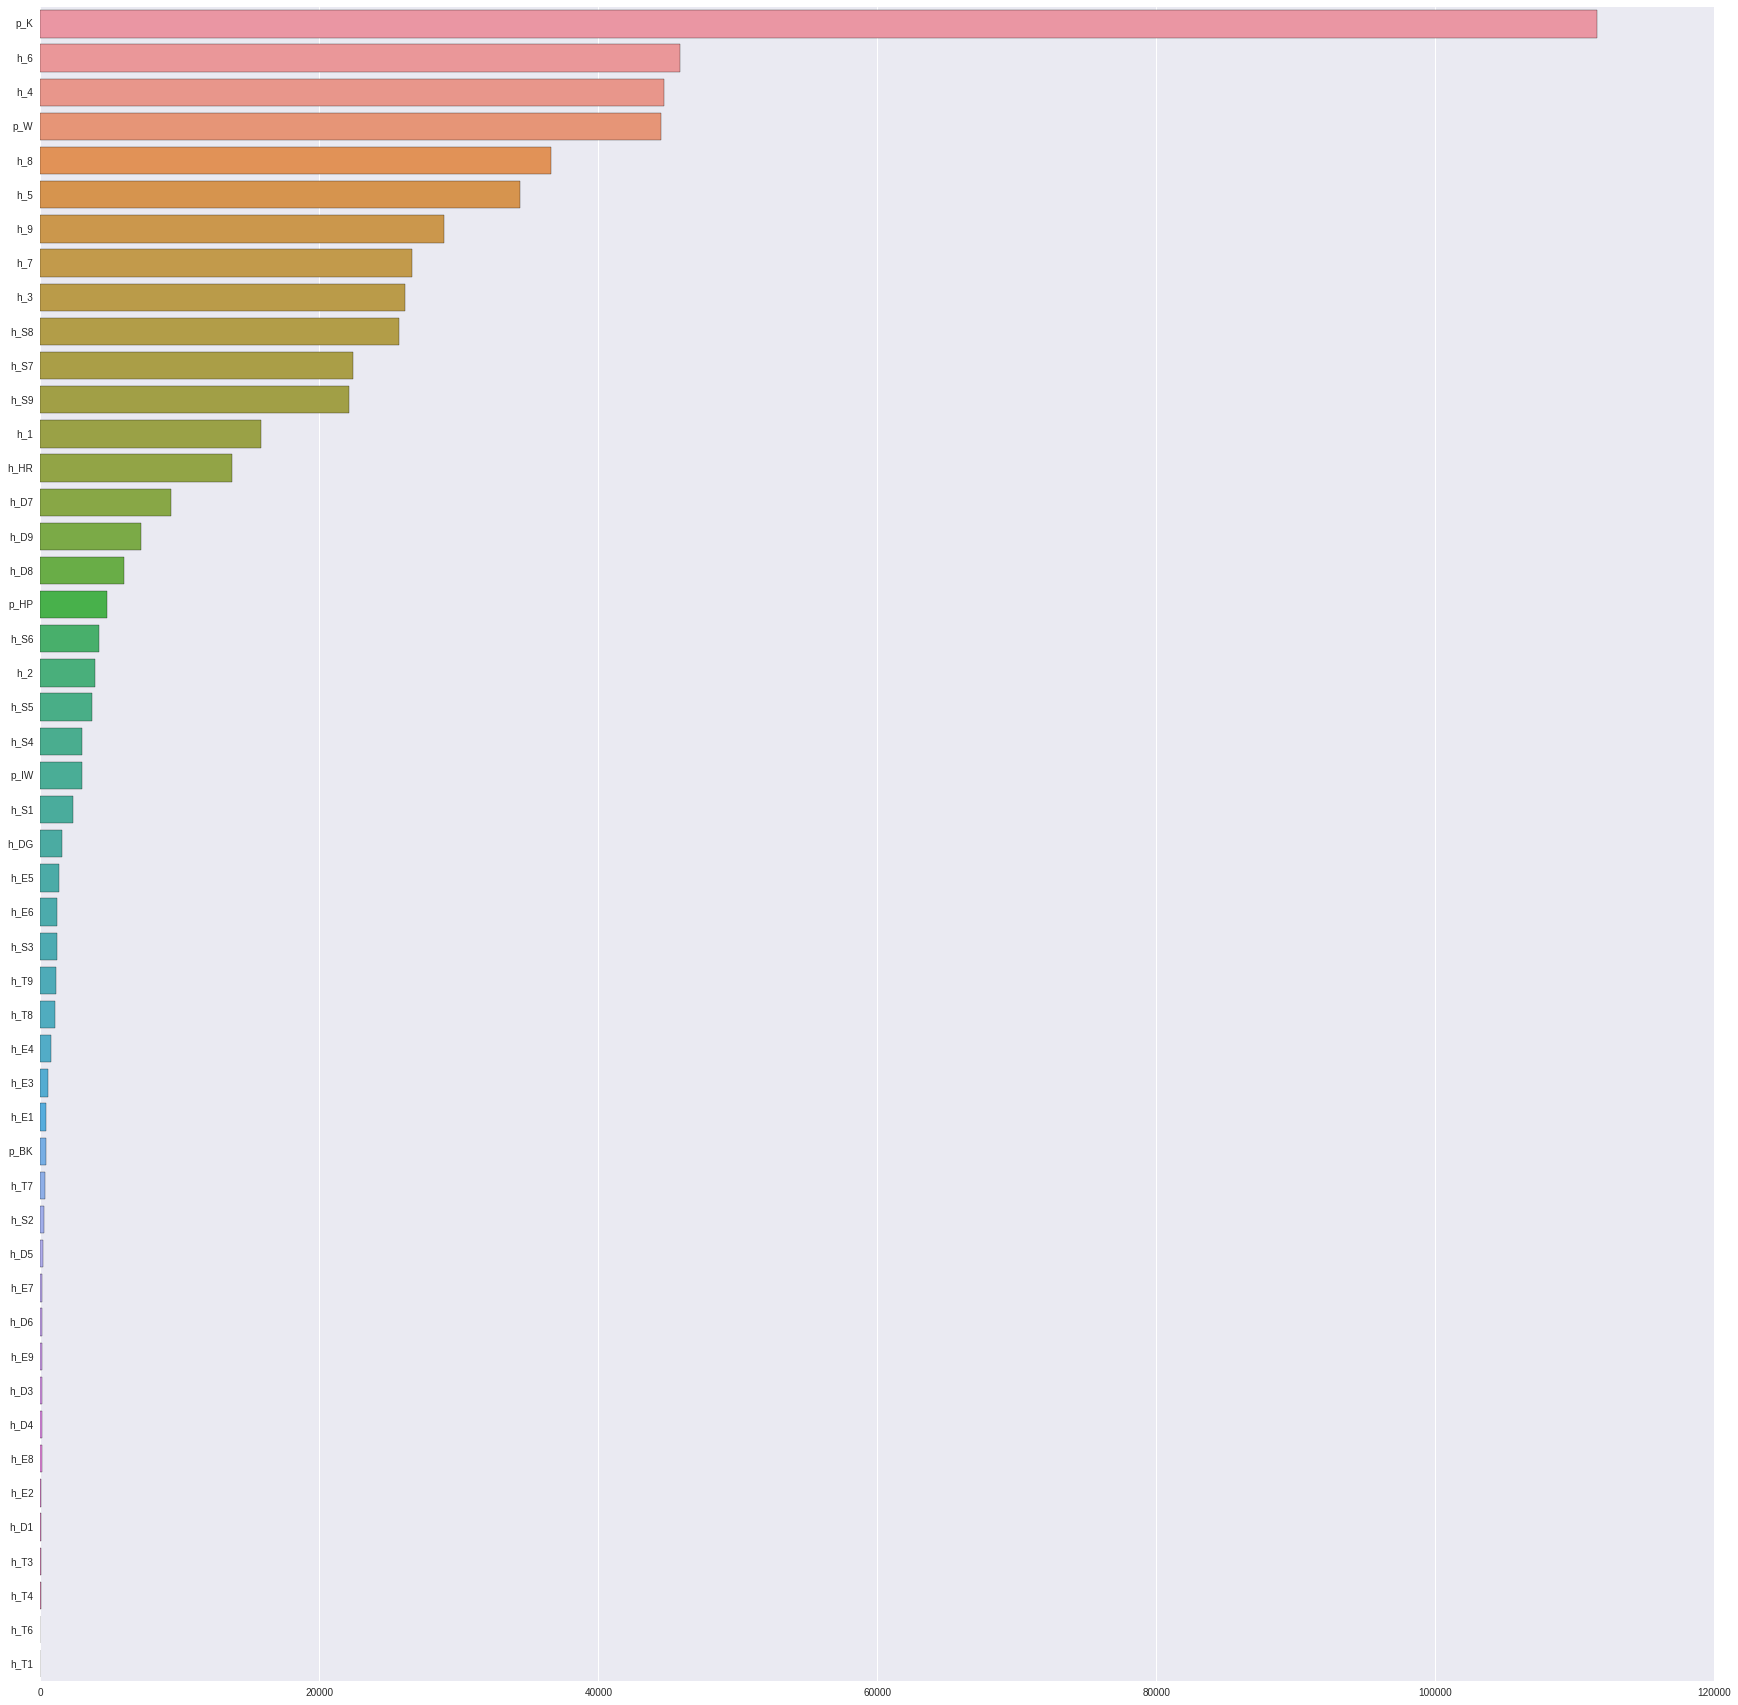

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

outcome_counts = {}
for year in train_years:
    for sample in data[year]:
        outcome = sample["outcome"]
        outcome_counts[outcome] = outcome_counts.get(outcome, 0) + 1

outcome_counts = list(outcome_counts.items())
outcome_counts.sort(key = lambda x: x[1], reverse = True)
val = [x[1] for x in outcome_counts]
symbols = [x[0] for x in outcome_counts]
pos = range(len(outcome_counts))

fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
ax = sns.barplot(x = val, y = symbols)
plt.show()

We'll then use these newly defined integer indices to build the appropriate NumPy arrays for our model.

In [8]:
import numpy as np

np.random.seed(FAV_NUM)

from keras.utils import np_utils

data_sets = {"batter": [], "pitcher": [], "outcome": []}
for sample in final_data:
    for column in sample:
        value = sample[column]
        value_index = category_to_int[column][value]
        data_sets[column].append([value_index])

for column in ["batter", "pitcher"]:
    data_sets[column] = np.array(data_sets[column])

data_sets["outcome"] = np_utils.to_categorical(np.array(data_sets["outcome"]), NUM_OUTCOMES)

Using Theano backend.


# Building and Training the Model

We're now ready to build our model with [Keras](http://keras.io/). The model is similar in spirit to the <code>word2vec</code> model in that we're trying to learn the player vectors that best predict the outcome of an at-bat (the "target word" in <code>word2vec</code>) given a certain batter and pitcher (the "context" in <code>word2vec</code>). We'll learn separate embedding matrices for batters and pitchers.

In [9]:
from keras import optimizers
from keras.layers import Activation, concatenate, Dense, Dropout, Embedding, Input, Reshape
from keras.models import Model

NUM_BATTERS = len(categories["batter"])
NUM_PITCHERS = len(categories["pitcher"])
VEC_SIZE = 9
ACTIVATION = "sigmoid"

batter_idx = Input(shape = (1, ), dtype = "int32", name = "batter_idx")
batter_embed = Embedding(NUM_BATTERS, VEC_SIZE, input_length = 1)(batter_idx)
batter_embed = Reshape((VEC_SIZE, ), name = "batter_embed")(batter_embed)
batter_embed = Activation(ACTIVATION)(batter_embed)

pitcher_idx = Input(shape = (1, ), dtype = "int32", name = "pitcher_idx")
pitcher_embed = Embedding(NUM_PITCHERS, VEC_SIZE, input_length = 1)(pitcher_idx)
pitcher_embed = Reshape((VEC_SIZE, ), name = "pitcher_embed")(pitcher_embed)
pitcher_embed = Activation(ACTIVATION)(pitcher_embed)

batter_pitcher = concatenate([batter_embed, pitcher_embed], name = "batter_pitcher")

output = Dense(NUM_OUTCOMES, activation = "softmax")(batter_pitcher)

model = Model(inputs = [batter_idx, pitcher_idx], outputs = [output])
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = "categorical_crossentropy")

And now we're ready to train our model. We'll save the weights at the end of training.

In [10]:
BATCH_SIZE = 100
NUM_EPOCHS = 100
VALID = False
validation_split = 0.0
callbacks = None
if VALID:
    from keras.callbacks import ModelCheckpoint
    validation_split = 0.01
    callbacks = [ModelCheckpoint("weights.h5", save_best_only = True, save_weights_only = True)]

X_list = [data_sets["batter"], data_sets["pitcher"]]
y = data_sets["outcome"]
history = model.fit(X_list, y, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                    verbose = 2, shuffle = True, callbacks = callbacks, validation_split = validation_split)
if not VALID:
    model.save_weights("weights.h5")

model.load_weights("weights.h5")
if VALID:
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc = "upper right")
    plt.show()

Epoch 1/100
5s - loss: 2.8693
Epoch 2/100
4s - loss: 2.8513
Epoch 3/100
4s - loss: 2.8504
Epoch 4/100
4s - loss: 2.8496
Epoch 5/100
4s - loss: 2.8486
Epoch 6/100
4s - loss: 2.8471
Epoch 7/100
4s - loss: 2.8450
Epoch 8/100
4s - loss: 2.8421
Epoch 9/100
4s - loss: 2.8387
Epoch 10/100
4s - loss: 2.8349
Epoch 11/100
5s - loss: 2.8311
Epoch 12/100
5s - loss: 2.8273
Epoch 13/100
4s - loss: 2.8233
Epoch 14/100
4s - loss: 2.8194
Epoch 15/100
6s - loss: 2.8161
Epoch 16/100
4s - loss: 2.8132
Epoch 17/100
4s - loss: 2.8108
Epoch 18/100
4s - loss: 2.8089
Epoch 19/100
4s - loss: 2.8073
Epoch 20/100
4s - loss: 2.8058
Epoch 21/100
4s - loss: 2.8045
Epoch 22/100
4s - loss: 2.8034
Epoch 23/100
5s - loss: 2.8023
Epoch 24/100
4s - loss: 2.8012
Epoch 25/100
4s - loss: 2.8004
Epoch 26/100
4s - loss: 2.7994
Epoch 27/100
4s - loss: 2.7985
Epoch 28/100
4s - loss: 2.7976
Epoch 29/100
4s - loss: 2.7969
Epoch 30/100
4s - loss: 2.7960
Epoch 31/100
4s - loss: 2.7952
Epoch 32/100
4s - loss: 2.7945
Epoch 33/100
4s -

We'll also train a logistic regression model so that we have something to compare to <code>(batter|pitcher)2vec</code>.

In [11]:
TRAIN_ALT = True
alt_model = None

if TRAIN_ALT:
    from scipy.sparse import csr_matrix, hstack
    from sklearn.linear_model import LogisticRegression

    X_batters = csr_matrix(np_utils.to_categorical(np.array(data_sets["batter"]), NUM_BATTERS))
    X_pitchers = csr_matrix(np_utils.to_categorical(np.array(data_sets["pitcher"]), NUM_PITCHERS))
    X = hstack([X_batters, X_pitchers])
    y = np.argmax(data_sets["outcome"], axis = 1)
    alt_model = LogisticRegression(n_jobs = -1)
    results = alt_model.fit(X, y)

# Qualitative Analysis of Player Vectors

Having trained the model, let's go ahead and fetch the distributed representations for all players. To do so, we need to define some functions that return a vector when provided with a player's integer index.

In [12]:
from keras import backend

get_batter_vec = backend.function([batter_idx], [batter_embed])
get_pitcher_vec = backend.function([pitcher_idx], [pitcher_embed])

# Retrieve distributed representation of players.
batter_vecs = get_batter_vec([np.array(range(NUM_BATTERS)).reshape((NUM_BATTERS, 1))])[0]
pitcher_vecs = get_pitcher_vec([np.array(range(NUM_PITCHERS)).reshape((NUM_PITCHERS, 1))])[0]
player_vecs = {"batter": batter_vecs, "pitcher": pitcher_vecs}

Alright, let's find out if these representations are revealing anything interesting. First, let's collect some information about the players.

In [13]:
# Retrieve player data.
player_data = {}

for data_file in data_files:
    if ".ROS" in data_file:
        f = open(join(data_directory, data_file))
        for line in f:
            parts = line.strip().split(",")
            player_id = parts[0]
            last_name = parts[1]
            first_name = parts[2]
            name = first_name + " " + last_name
            batting_hand = parts[3]
            throwing_hand = parts[4]
            position = parts[6]
            player_data[player_id] = {"name": name, "batting_hand": batting_hand,
                                      "throwing_hand": throwing_hand, "position": position}

## t-SNE

Next, we'll use the [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm to visualize the player vectors in two and three dimensions.

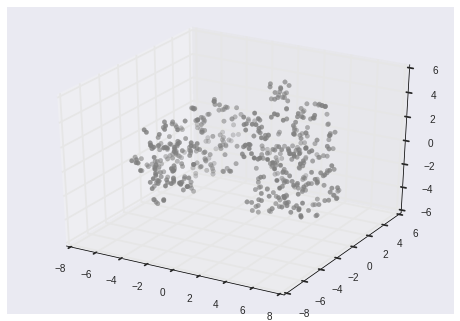

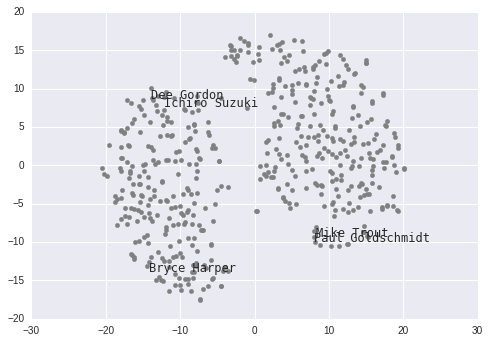

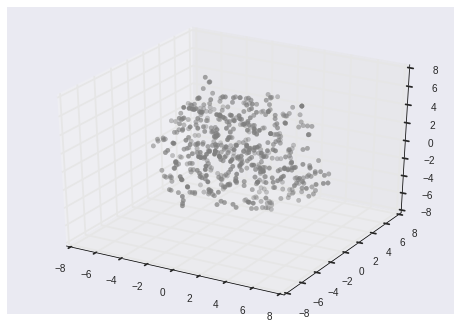

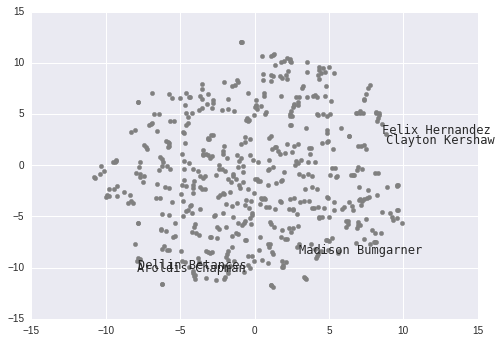

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

NUM_PLAYERS = {"batter": NUM_BATTERS, "pitcher": NUM_PITCHERS}


def run_tsne(player_type):
    """Run t-SNE on the player vectors.

    :param player_type: 
    :return: 
    """
    params = {"batter": {"perplexity": 20, "learning_rate": 200, "init": "pca"},
              "pitcher": {"perplexity": 20, "learning_rate": 200, "init": "random"}}
    tsne = TSNE(n_components = 3, **params[player_type])
    manifold_3d = tsne.fit_transform(player_vecs[player_type])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = "3d")
    ax.scatter(manifold_3d[:, 0], manifold_3d[:, 1], manifold_3d[:, 2], color = "gray")
    
    plt.show()

    params = {"batter": {"perplexity": 20, "learning_rate": 550, "init": "pca"},
              "pitcher": {"perplexity": 20, "learning_rate": 200, "init": "random"}}
    tsne = TSNE(n_components = 2, **params[player_type])
    manifold_2d = tsne.fit_transform(player_vecs[player_type])
    (x, y) = (manifold_2d[:, 0], manifold_2d[:, 1])
    
    plt.scatter(x, y, color = "gray")
    interesting_batters = {"Mike Trout", "Paul Goldschmidt", "Dee Gordon", "Ichiro Suzuki",
                           "Bryce Harper"}
    interesting_pitchers = {"Clayton Kershaw", "Felix Hernandez", "Madison Bumgarner",
                            "Aroldis Chapman", "Dellin Betances"}
    interesting_players = {"batter": interesting_batters, "pitcher": interesting_pitchers}
    for i in range(NUM_PLAYERS[player_type]):
        player_id = categories[player_type][i]
        player_name = player_data[player_id]["name"]
        if player_name in interesting_players[player_type]:
            plt.text(x[i], y[i], player_name, va = "top", family = "monospace")

    plt.show()

    return manifold_3d


tsne_batters = run_tsne("batter")
tsne_pitchers = run_tsne("pitcher")

## PCA

Let's also visualize the first few PCs of a [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) of the vectors and color them with various interesting properties.

In [15]:
import csv
import pandas as pd

playerID_to_retroID = {}
reader = csv.DictReader(open("Master.csv"))
for row in reader:
    playerID = row["playerID"]
    retroID = row["retroID"]
    playerID_to_retroID[playerID] = retroID

# Get player salaries.
reader = csv.DictReader(open("Salaries.csv"))
salaries = {}
for row in reader:
    if row["yearID"] == "2015":
        playerID = row["playerID"]
        retroID = playerID_to_retroID[playerID]
        log_salary = np.log2(int(row["salary"]))
        salaries[retroID] = log_salary

# Set up other inteteresting data for coloring.
max_hr_rate = max([home_runs.get(batter_id, 0) / at_bats[batter_id] for batter_id in at_bats if batter_id in categories["batter"]])
max_single_rate = max([singles.get(batter_id, 0) / at_bats[batter_id] for batter_id in at_bats if batter_id in categories["batter"]])
max_double_rate = max([doubles.get(batter_id, 0) / at_bats[batter_id] for batter_id in at_bats if batter_id in categories["batter"]])
max_salary = max([salaries.get(batter_id, 0) for batter_id in at_bats if batter_id in categories["batter"]])

batter_colors = {"player_id": [], "hand": [], "Home Runs": [], "Singles": [], "Doubles": [], "salary": []}
for i in range(NUM_BATTERS):
    batter_id = categories["batter"][i]
    batting_hand = player_data[batter_id]["batting_hand"]
    batter_colors["player_id"].append(batter_id)
    batter_colors["hand"].append(batting_hand)
    # batter_colors["Home Runs"].append(str((home_runs.get(batter_id, 0) / at_bats[batter_id]) / max_hr_rate))
    batter_colors["Home Runs"].append(str(home_runs.get(batter_id, 0) / at_bats[batter_id]))
    batter_colors["Singles"].append(str(singles.get(batter_id, 0) / at_bats[batter_id]))
    batter_colors["Doubles"].append(str((doubles.get(batter_id, 0) / at_bats[batter_id]) / max_double_rate))
    batter_colors["salary"].append(str((salaries.get(batter_id, 0) / max_salary)))

df = pd.DataFrame(batter_colors)

In [16]:
from sklearn import decomposition

# Run PCA.
pca = decomposition.PCA()

pca.fit(batter_vecs)
print(pca.explained_variance_ratio_)
projected_batters = pca.transform(batter_vecs)

pca.fit(pitcher_vecs)
print(pca.explained_variance_ratio_)
projected_pitchers = pca.transform(pitcher_vecs)

[ 0.26991175  0.23425182  0.11188291  0.10422799  0.07458872  0.06611303
  0.0583346   0.05216778  0.02852139]
[ 0.24629598  0.20721271  0.14406648  0.09974791  0.08888732  0.07580126
  0.05307036  0.04557328  0.0393447 ]


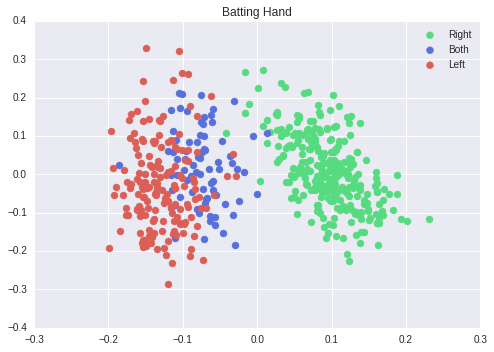

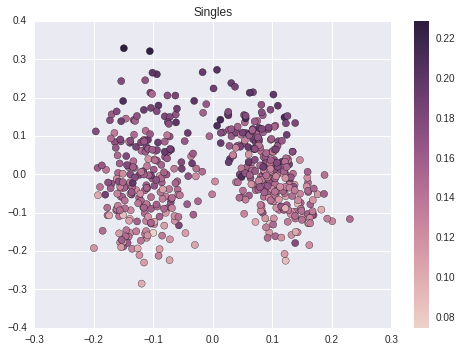

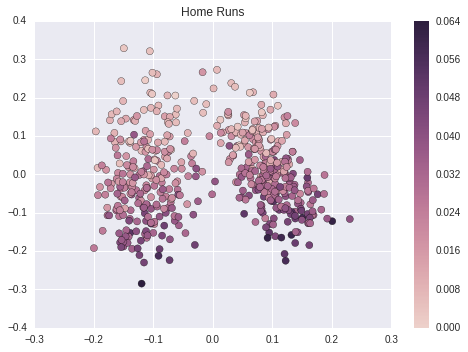

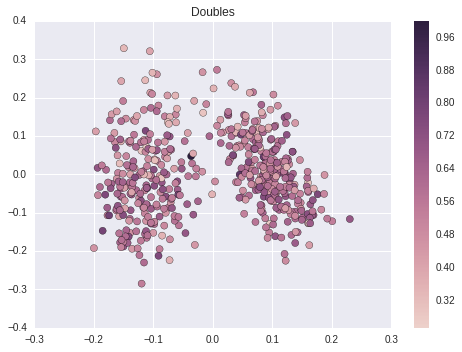

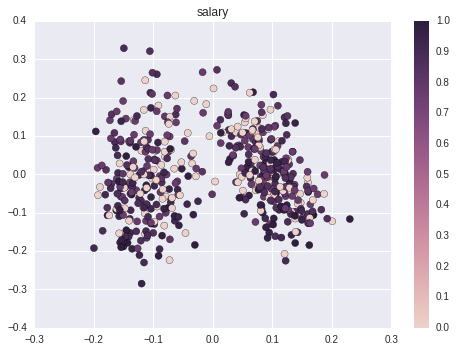

In [17]:
for i in range(3):
    df["pc{0}".format(i + 1)] = projected_batters[:, i]

cmap = sns.cubehelix_palette(as_cmap = True)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection = "3d")
# ax.scatter(projected_batters[:, 0], projected_batters[:, 1], projected_batters[:, 2], color = df["Home Runs"], cmap = cmap)
# ax.set_title("Batters")
# plt.show()

cs = sns.color_palette("hls", 8)
batting_hand_color = {"Left": cs[0], "Right": cs[3], "Both": cs[5]}
legend_data = []
legend_names = []
for (hand, color) in batting_hand_color.items():
    batter_hands = df[df["hand"] == hand[0]]
    legend_data.append(plt.scatter(batter_hands["pc1"], batter_hands["pc2"], s = 50, color = color))
    legend_names.append(hand)

plt.title("Batting Hand")
plt.legend(legend_data, legend_names)
plt.show()

for batter_color in ["Singles", "Home Runs", "Doubles", "salary"]:
    (f, ax) = plt.subplots()
    points = ax.scatter(df["pc1"], df["pc2"], c = df[batter_color], s = 50, cmap = cmap)
    f.colorbar(points)
    ax.set_title(batter_color)
    plt.show()

As you can see, there are some interesting patterns emerging from the representations. For example, right-handed hitters are clearly separated from left-handed and switch hitters. Similarly, frequent singles hitters are far from infrequent singles hitters. So, the model is clearly learning something, but whether or not what it's learning is non-trivial remains to be seen. Let's go ahead and save the t-SNE map and PC scores to CSV files so that we can play around with them elsewhere.

In [18]:
import csv


def write_viz_data(player_type, projected, fieldnames, projection):
    """Write the visualization coordinates of the players to a file.
    
    :param player_type: 
    :param projected: 
    :param fieldnames: 
    :return: 
    """
    out = open("{0}s_{1}.csv".format(player_type, projection), "w")
    output = csv.DictWriter(out, fieldnames = fieldnames)
    output.writeheader()
    
    for i in range(NUM_PLAYERS[player_type]):
        player_id = categories[player_type][i]
        row = {}
        for col in fieldnames:
            if col in player_data[player_id]:
                row[col] = player_data[player_id][col]
        
        row["2015_salary"] = 2 ** salaries.get(player_id, 0)
        
        xyz = ["x", "y", "z"]
        for j in range(3):
            if projection == "pca":
                row["PC{0}".format(j + 1)] = projected[i][j]
            else:
                row[xyz[j]] = projected[i][j]
        
        row["player_id"] = player_id
        if player_type == "batter":
            row["hr_rate"] = home_runs.get(player_id, 0) / at_bats[player_id]
        
        nothing = output.writerow(row)
    
    out.close()


fieldnames = ["player_id", "name", "2015_salary", "position", "batting_hand", "throwing_hand", "hr_rate", "PC1", "PC2", "PC3"]
write_viz_data("batter", projected_batters, fieldnames, "pca")
write_viz_data("batter", tsne_batters, fieldnames[:-3] + ["x", "y", "z"], "tsne")

fieldnames = ["player_id", "name", "2015_salary", "throwing_hand", "PC1", "PC2", "PC3"]
write_viz_data("pitcher", projected_pitchers, fieldnames, "pca")
write_viz_data("pitcher", tsne_pitchers, fieldnames[:-3] + ["x", "y", "z"], "tsne")

Let's also save the raw player vectors.

In [19]:
def write_distributed_representations(player_type, player_vecs):
    """Write the player vectors to a file.
    
    :param player_type: 
    :param player_vecs: 
    :return: 
    """
    out = open("{0}s_latent.csv".format(player_type), "w")
    fieldnames = ["player_id", "name"] + ["latent_{0}".format(i + 1) for i in range(VEC_SIZE)]
    output = csv.DictWriter(out, fieldnames = fieldnames)
    output.writeheader()
    
    for i in range(NUM_PLAYERS[player_type]):
        player_id = categories[player_type][i]
        row = {"player_id": player_id,
               "name": player_data[player_id]["name"]}
        
        for j in range(VEC_SIZE):
            row["latent_{0}".format(j + 1)] = player_vecs[i][j]
        
        nothing = output.writerow(row)
    
    out.close()


write_distributed_representations("batter", batter_vecs)
write_distributed_representations("pitcher", pitcher_vecs)

## ScatterPlot3D

To gain some additional intuition with the player representations, I recommend exploring them in my open source scatter plot visualization application, [ScatterPlot3D](https://sites.google.com/view/michaelaalcorn/projects/scatterplot3d). To run it:

1. Download the appropriate build.
2. Run with <code>java -jar ScatterPlot3D-&lt;version&gt;.jar</code> on Linux systems or by double-clicking the JAR on Windows.
3. Load the data.
4. Put 5, 6, and 7 for x, y, and z for "pitchers_tsne.csv" or 8, 9, and 10 for "batters_tsne.csv".
5. Click "Submit".

You can then search, zoom, and rotate the data, and click on individual points for more details. For example:

<img src="batters_tsne_all.png" width="600">

<img src="trout_goldschmidt.png" width="600">

Documentation can be downloaded [here](https://sites.google.com/view/michaelaalcorn/ScatterPlot3D/SupplementaryMaterials.zip?attredirects=0&d=1) and a gallery of application screenshots can be found [here](http://imgur.com/a/U833y).

# Player Algebra

## Nearest Neighbors

So, do these vectors contain any non-obvious information? Maybe comparing nearest neighbors will provide some insight.

In [20]:
import pandas as pd


def get_nearest_neighbors(name, data, latent_vecs, player_names, k = 5):
    """Print the k nearest neighbors (in the latent space) of a given player.
    
    :param name: 
    :param data: 
    :param latent_vecs: 
    :param player_names: 
    :param k: 
    :return: 
    """
    player_index = np.where(data["name"] == name)[0]
    player_latent = latent_vecs[player_index]
    print(player_latent[0])
    # distances = list(np.linalg.norm(latent_vecs - player_latent, axis = 1))
    distances = 1 - np.dot(latent_vecs, player_latent.T).flatten() / (np.linalg.norm(latent_vecs, axis = 1) * np.linalg.norm(player_latent))
    distances_and_ids = list(zip(player_names, distances))
    distances_and_ids.sort(key = lambda x: x[1])
    
    return distances_and_ids[1:1 + k]


data_files = ["batters_latent.csv", "pitchers_latent.csv"]
player_df = {}
player_names = {}
player_ids = {}
latent_vecs = {}
for player_type in ["batter", "pitcher"]:
    data_file = "{0}s_latent.csv".format(player_type)
    player_df[player_type] = pd.read_csv(data_file)
    player_ids[player_type] = list(player_df[player_type]["player_id"])
    player_names[player_type] = list(player_df[player_type]["name"])
    latent_vecs[player_type] = np.array(player_df[player_type].iloc[:, 2:])


for batter in ["Mike Trout", "Dee Gordon"]:
    print(batter)
    print(get_nearest_neighbors(batter, player_df["batter"], latent_vecs["batter"], player_names["batter"]))
    print()

for pitcher in ["Clayton Kershaw", "Aroldis Chapman", "Jake Arrieta", "Felix Hernandez"]:
    print(pitcher)
    print(get_nearest_neighbors(pitcher, player_df["pitcher"], latent_vecs["pitcher"], player_names["pitcher"]))
    print()

Mike Trout
[ 0.520534  0.28765   0.477526  0.527923  0.459255  0.423887  0.4969
  0.318814  0.286775]
[('Paul Goldschmidt', 0.0066666041494067851), ('Justin Upton', 0.0073453654472483976), ('Josh Donaldson', 0.0078413271524069295), ('Ryan Zimmerman', 0.0079034035788370094), ('Nelson Cruz', 0.0082053890571556209)]

Dee Gordon
[ 0.32075   0.539803  0.364377  0.344089  0.356913  0.434861  0.249452
  0.541931  0.481247]
[('Ichiro Suzuki', 0.002615398979108452), ('James Jones', 0.0059187648697827111), ('Ender Inciarte', 0.0070434974102867587), ('Billy Burns', 0.0070548411592834537), ('Ben Revere', 0.0073334395835736865)]

Clayton Kershaw
[ 0.582727  0.583321  0.540175  0.609195  0.564538  0.629121  0.547802
  0.459402  0.492474]
[('Craig Stammen', 0.0015347980495676872), ('Zack Greinke', 0.0017442569789246631), ('Jose Quintana', 0.0018445652773056986), ('Carlos Carrasco', 0.001866511900549872), ('Fausto Carmona', 0.0020877750294346908)]

Aroldis Chapman
[ 0.620969  0.409188  0.411944  0.643

At a first glance, the nearest neighbors produced by the embedding do seem to support baseball intuition. Both Mike Trout and Paul Goldschmidt are known for their [rare blend of speed and power](https://sports.vice.com/en_us/article/paul-goldschmidt-might-really-be-this-good). Like [Dee Gordon](http://ftw.usatoday.com/2015/06/dee-gordon-miami-marlins-inside-park-home-run), Ichiro Suzuki [has a knack for being able to get on base](http://www.fangraphs.com/blogs/dee-gordon-has-been-going-full-ichiro/).

Zack Greinke's presence among Clayton Kershaw's nearest neighbors is interesting as they are considered [one of the best pitching duos of all time](https://www.si.com/cauldron/2015/09/17/clayton-kershaw-zack-greinke-cy-young-mlb). The similarities between Craig Stammen and Kershaw are not obvious to my ignorant baseball eye, but we would expect a method like <code>(batter|pitcher)2vec</code> (if effective) to occasionally discover surprising neighbors or else it wouldn't be particularly useful.

Aroldis Chapman's nearest neighbors are fairly unsurprising with [Craig Kimbrel](https://www.scientificamerican.com/article/the-documentary-fastball-tosses-some-physics-at-fans/) and [Andrew Miller](http://www.cbssports.com/mlb/news/world-series-from-teammates-to-foes-indians-andrew-miller-cubs-aroldis-chapman-meet-again/) both being elite relief pitchers.

When clustering players using common MLB stats (e.g., HRs, RBIs), Mike Trout's ten nearest neighbors for the 2015 season are: Bryce Harper, Julio Daniel Martinez, Andrew McCutchen, Justin Upton, Matt Carpenter, Joey Votto, Curtis Granderson, Kris Bryant, Chris Davis, and Brian Dozier (R code [here](https://github.com/airalcorn2/batter-pitcher-2vec/blob/master/raw_stats_neighbors.R)). So there is some overlap between the two neighborhood methods, but, intriguingly, the nearest neighbor from each method is not found in the neighborhood of the other method. Similarly, Ichiro isn't among Dee Gordon's ten nearest neighbors when clustering on standard MLB stats.

## Opposite-handed Doppelgängers

Another fun thing to try is analogies. As I mentioned at the beginning of this notebook, word embeddings often contain interesting analogy properties. [Erik Erlandson](https://www.linkedin.com/in/erikerlandson), a colleague of mine at Red Hat, suggested I use average vectors for right-handed and left-handed batters to generate opposite-handed doppelgängers for different players. Let's see what that looks like.

In [21]:
def get_opposite_hand(name, batting_hand, df, latent_vecs, player_names, k = 10):
    """Find the player's opposite batting hand doppelgänger.
    
    :param name: 
    :param batting_hand: 
    :param df: 
    :param latent_vecs: 
    :param player_names: 
    :param k: 
    :return: 
    """
    player_index = np.where(df["name"] == name)[0]
    player_latent = latent_vecs[player_index]
    player_latent + average_batters["R"]
    opposite_hand = None
    if batting_hand == "R":
        opposite_hand = player_latent - average_batters["R"] + average_batters["L"]
    else:
        opposite_hand = player_latent - average_batters["L"] + average_batters["R"]
    
    # distances = list(np.linalg.norm(latent_vecs - opposite_hand, axis = 1))
    distances = 1 - np.dot(latent_vecs, opposite_hand.T).flatten() / (np.linalg.norm(latent_vecs, axis = 1) * np.linalg.norm(opposite_hand))
    distances_and_ids = list(zip(player_names, distances))
    distances_and_ids.sort(key = lambda x: x[1])
    
    return distances_and_ids[:k]


# Generate average vectors for each batting hand.
average_batters = {"R": [], "L": [], "B": []}

for player_id in player_data:
    hand = player_data[player_id]["batting_hand"]
    batter_index = np.where(player_df["batter"]["player_id"] == player_id)[0]
    batter_latent = latent_vecs["batter"][batter_index]
    if len(batter_latent) > 0:
        average_batters[hand] += [batter_latent]

for batting_hand in average_batters:
    average_batters[batting_hand] = np.array(average_batters[batting_hand]).mean(axis = 0)

# Get opposite-handed doppelgängers.
print("Mike Trout")
print(get_opposite_hand("Mike Trout", "R", player_df["batter"], latent_vecs["batter"], player_names["batter"]))
print()

print("Dee Gordon")
print(get_opposite_hand("Dee Gordon", "L", player_df["batter"], latent_vecs["batter"], player_names["batter"]))
print()

Mike Trout
[('Chris Davis', 0.0049258077236066233), ('David Ortiz', 0.0058024017992437393), ('Bryce Harper', 0.006010968153819074), ('Freddie Freeman', 0.008398382585441011), ('Lucas Duda', 0.0087481282791669335), ('Anthony Rizzo', 0.0093898982871460923), ('Adrian Gonzalez', 0.01036470879509388), ('Adam LaRoche', 0.010405920691784254), ('Adam Dunn', 0.010735644454047844), ('Justin Smoak', 0.011291060788544693)]

Dee Gordon
[('Tyler Saladino', 0.010115897107975891), ('Bryan Holaday', 0.011586509022512459), ('Wil Nieves', 0.011736466202684426), ('Billy Burns', 0.012207322852553881), ('Jose Iglesias', 0.0123966125881525), ('Eduardo Nunez', 0.012412907598100986), ('Kevin Frandsen', 0.012552296317504763), ('Pedro Ciriaco', 0.012974644768371291), ('Christian Bethancourt', 0.013103371437111155), ('Miguel Rojas', 0.013631948599752475)]



Bryce Harper's presence among Mike Trout's left-handed doppelgängers [is particularly satisfying](http://www.sportingnews.com/mlb/news/sn50-2016-best-baseball-players-mike-trout-bryce-harper/mk3kmorbiyhr1f7onb7t5pehq). As for Dee Gordon's right-handed doppelgängers, Tyler Saladino is known for "[legging 'em out](http://www.fangraphs.com/fantasy/all-aboard-the-tyler-saladino-hype-train/)".

# Modeling Previously Unseen At-Bat Matchups

Measuring how well the <code>(batter|pitcher)2vec</code> representations predict outcome distributions for unseen matchups is the ultimate test of whether the representations are capturing anything meaningful about players. To test the model, we'll look at matchups from the 2016 season that were not seen in the training set.

In [22]:
matchup_counts = {}
outcome_counts = {}

for sample in data[test_year]:
    batter = sample["batter"]
    pitcher = sample["pitcher"]
    matchup = "{0}_{1}".format(batter, pitcher)
    if batter in categories["batter"] and pitcher in categories["pitcher"] and matchup not in matchups:
        matchup_counts[matchup] = matchup_counts.get(matchup, 0) + 1
        if matchup not in outcome_counts:
            outcome_counts[matchup] = {}
        
        outcome_counts[matchup][outcome] = outcome_counts[matchup].get(outcome, 0) + 1

matchup_counts = list(matchup_counts.items())
matchup_counts.sort(key = lambda x: -x[1])

To determine the effectiveness of <code>(batter|pitcher)2vec</code>, we need something to first establish a baseline. We'll use a naïve prediction strategy to fill that role. For any given batter, we'll define their expected outcome distribution as:

$$p(o_i|b_j)=\frac{c_{i,j} + r_i}{\sum_{k=1}^{K} c_{j,k} + 1}$$

where $o_i$ denotes the outcome indexed by $i$, $c_{i,j}$ is the number of times the player indexed by $j$ had an at-bat resulting in the outcome indexed by $i$ in the training data, $r_i$ is the proportion of all at-bats that resulted in the outcome indexed by $i$ in the training data, and $K$ is the number of possible outcomes. Essentialy, the procedure adds one at-bat to each batter, but distributes the mass of that single bat across all outcomes based on data from all batters. You can think of $r_i$ as a type of "prior" or smoothing factor. $p(o_i|p_j)$ will be similarly defined. Finally, we'll define the expected outcome distribution for a given batter/pitcher matchup as:

$$p(o_i|b_j,p_k) = \frac{p(o_i|b_j) + p(o_i|p_k)}{2}$$

In [23]:
def get_past_outcome_counts(train_years, data, test_players, player_type):
    """Retrieve past outcome counts for a given player in the training set.
    
    :param train_years: 
    :param data: 
    :param test_players: 
    :param player_type: 
    """
    past_outcome_counts = {}
    for year in train_years:
        for sample in data[year]:
            player = sample[player_type]
            if player in test_players:
                outcome = sample["outcome"]
                if player not in past_outcome_counts:
                    past_outcome_counts[player] = {}

                past_outcome_counts[player][outcome] = past_outcome_counts[player].get(outcome, 0) + 1
    
    return past_outcome_counts


cutoff = 0
total_above = sum(1 for matchup_count in matchup_counts if matchup_count[1] >= cutoff)
TOP_MATCHUPS = total_above
print("Total Matchups: {0}".format(TOP_MATCHUPS))

test_batters = {matchup[0].split("_")[0] for matchup in matchup_counts[:TOP_MATCHUPS]}
test_pitchers = {matchup[0].split("_")[1] for matchup in matchup_counts[:TOP_MATCHUPS]}
test_matchups = {matchup[0] for matchup in matchup_counts[:TOP_MATCHUPS]}

past_batter_outcome_counts = get_past_outcome_counts(train_years, data, test_batters, "batter")
past_pitcher_outcome_counts = get_past_outcome_counts(train_years, data, test_pitchers, "pitcher")

# Get total outcome counts from training data.
train_outcome_counts = {}
for year in train_years:
    for sample in data[year]:
        outcome = sample["outcome"]
        train_outcome_counts[outcome] = train_outcome_counts.get(outcome, 0) + 1

# Convert total outcome counts into a probability distribution.
total_outcomes = sum(train_outcome_counts.values())
for outcome in train_outcome_counts:
    train_outcome_counts[outcome] /= total_outcomes

past_batter_probs = {}
for batter in test_batters:
    past_batter_outcome_total = sum(past_batter_outcome_counts[batter].values())
    past_batter_probs[batter] = {}
    for outcome in train_outcome_counts:
        past_batter_probs[batter][outcome] = (past_batter_outcome_counts[batter].get(outcome, 0) + train_outcome_counts[outcome]) / (past_batter_outcome_total + 1)

past_pitcher_probs = {}
for pitcher in test_pitchers:
    past_pitcher_outcome_total = sum(past_pitcher_outcome_counts[pitcher].values())
    past_pitcher_probs[pitcher] = {}
    for outcome in train_outcome_counts:
        past_pitcher_probs[pitcher][outcome] = (past_pitcher_outcome_counts[pitcher].get(outcome, 0) + train_outcome_counts[outcome]) / (past_pitcher_outcome_total + 1)

Total Matchups: 21479


We can then calculate the log loss of this naïve approach on unseen matchups.

In [24]:
from statsmodels.stats.weightstats import ttest_ind

test_data_sets = {"batter": [], "pitcher": [], "outcome": []}
naive_losses = []

for sample in data[test_year]:
    
    batter = sample["batter"]
    pitcher = sample["pitcher"]
    matchup = "{0}_{1}".format(batter, pitcher)
    if matchup not in test_matchups:
        continue
        
    outcome = sample["outcome"]
    
    past_batter_prob = past_batter_probs[batter][outcome]
    past_pitcher_prob = past_pitcher_probs[pitcher][outcome]
    
    naive_prob = (past_batter_prob + past_pitcher_prob) / 2
    naive_loss = -np.log(naive_prob)
    naive_losses.append(naive_loss)
    
    for column in sample:
        value = sample[column]
        value_index = category_to_int[column][value]
        test_data_sets[column].append([value_index])

avg_naive_loss = sum(naive_losses) / len(naive_losses)
print("Naïve Loss: {0:.4f}".format(avg_naive_loss))
print(len(naive_losses))

Naïve Loss: 2.8113
51580


And we can now see how <code>(batter|pitcher)2vec</code> compares.

In [25]:
for column in ["batter", "pitcher"]:
    test_data_sets[column] = np.array(test_data_sets[column])

X_list = [test_data_sets["batter"], test_data_sets["pitcher"]]
y = test_data_sets["outcome"]

preds = model.predict(X_list)
# result = model.evaluate(X_list, np_utils.to_categorical(np.array(test_data_sets["outcome"]), NUM_OUTCOMES), verbose = 0)
# print(result)
net_losses = []
for i in range(preds.shape[0]):
    net_loss = -np.log(preds[i][y[i]][0])
    net_losses.append(net_loss)

avg_net_loss = sum(net_losses) / len(net_losses)
print("(batter|pitcher)2vec: {0:.4f}".format(avg_net_loss))
print(len(net_losses))

(batter|pitcher)2vec: 2.7848
51580


In [26]:
print("{0:.2f}% fewer bits on average.".format(100 * (1 - avg_net_loss / avg_naive_loss)))
print(ttest_ind(net_losses, naive_losses, alternative = "smaller"))

0.94% fewer bits on average.
(-3.8591196368521254, 5.6932720822180356e-05, 103158.0)


As you can see, <code>(batter|pitcher)2vec</code> is a significantly better at modeling outcome distributions for unseen batter/pitcher matchups than the naïve baseline. But is an improvement of only 0.94% over the baseline particularly impressive? Let's see how our logistic regression model fairs.

In [27]:
if TRAIN_ALT:
    X_batters = csr_matrix(np_utils.to_categorical(np.array(test_data_sets["batter"]), NUM_BATTERS))
    X_pitchers = csr_matrix(np_utils.to_categorical(np.array(test_data_sets["pitcher"]), NUM_PITCHERS))
    X = hstack([X_batters, X_pitchers])

    preds = alt_model.predict_proba(X)
    lr_losses = []
    for i in range(preds.shape[0]):
        lr_loss = -np.log(preds[i][y[i]][0])
        lr_losses.append(lr_loss)

    avg_lr_loss = sum(lr_losses) / len(lr_losses)
    print("Logistic Regression: {0:.4f}".format(avg_lr_loss))
    print(len(lr_losses))

    print("{0:.2f}% fewer bits on average.".format(100 * (1 - avg_lr_loss / avg_naive_loss)))
    print(ttest_ind(lr_losses, naive_losses, alternative = "smaller"))

Logistic Regression: 2.8118
51580
-0.02% fewer bits on average.
(0.077115896971247822, 0.53073425186932943, 103158.0)


The logistic regression model actually performs slightly worse than our naïve approach! The neural net strategy seems to be a promising one.